# Градиентный спуск

Решить методом градиентного спуска уравнение $x^{2}+5x-4=0$.

**Вопросы**.
1. Для чего используется градиентный спуск?  

Градиентный спуск используется для оптимизации функций, минимизации ошибок и нахождения минимума функций. Он ищет минимум функции, двигаясь в направлении наибольшего убывания градиента функции.

2. Для какой функции L будем его применять в данной задаче?  

abs(x^2 + 5x - 4)

3. Чему равна производная L по x?  

Производная функции L(x) по x будет равна ((2*x + 5)(x^2 + 5x - 4))/abs(x^2 + 5x - 4).

4. Какие проблемы возникают при использовании градиентного спуска при решении этой задачи?  

Правильный подбор функции L(x), подбор правильных значений скорости градиентного спуска и максимального количества итераций...

In [8]:
x = -10 #Начальная точка
L = x*x+5*x-4 #Функция для которой применяем градиентный спуск
alpha = 0.01 #Скорость градиентного спуска
max_iter = 100000 #Максимальное количество итераций
for i in range(max_iter):
    dL = ((2*x+5)*(x*x+5*x-4))/abs(x*x+5*x-4) #Производная этой функции
    x -= alpha * dL
print(x, x ** 2 + 5 * x - 4)

-5.733151097055307 0.20326601638993935


# Логистическая регрессия

Основной задачей будет обучение классификатор на базе логистической регрессии, чтобы отбирать изображения, на которых есть котики.

**Инструкции:**
- Не использовать циклы (for/while) в коде, кроме случаев, где напрямую это разрешается.

**Вы узнаете как:**
- Строить общую архитектуру алгоритма обучения, включая:
    - Инициализацию параметров
    - Вычисление функции стоимости и ее градиент
    - Использование алгоритма оптимизации (градиентный спуск) 
- Собрать перечисленные выше функции в основную функцию модели в правильном порядке.

## 1 - Пакеты ##

Для начала, запустим ячейку ниже, чтобы импортировать все пакеты, которые понадобятся вам по мере выполнения практики.
- [h5py](http://www.h5py.org) библиотека для взаимодействия с датасетом в Н5-файле
- [matplotlib](http://matplotlib.org) библиотека для построения графиков/визуализации.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image

%matplotlib inline

## 2 - Исследование проблемы ##

**Проблема**: Вам дается датасет ("data.h5") содержащий:  
- тренировочную выборку m_train изображений, с маркировками "котик" (y=1) или "не котик" (y=0)  
- тестовую выборку m_test изображений с маркировками котик/не котик  
- все изображения размерностью (num_px, num_px, 3), где 3 соответствует трехканальной передаче цвета (RGB). Т.е. каждое изображение - квадрат (height = num_px) и (width = num_px).  

Необходимо написать простой алгоритм распознавания изображения, который сможет корректно классифицировать, есть ли на изображении кошка.

Давайте познакомимся с датасетом. Загрузите данные, запустив ячейку ниже.

In [34]:
# Загружаем данные
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Добавили "_orig" в конце датасетов, потому что будем их в дальнейшем обрабатывать. После обработки у нас будут train_set_x и test_set_x (названия train_set_y и test_set_y не нуждаются в предварительной обработке).

Каждая строка train_set_x_orig и test_set_x_orig является массивой, описывающим изображение. Можете вывести его и посмотрев, выполнив код ниже. Можно менять значение `index` и перезапустить ячейку, чтобы посмотреть другие картинки. 

y = [1], it's a 'cat' picture.


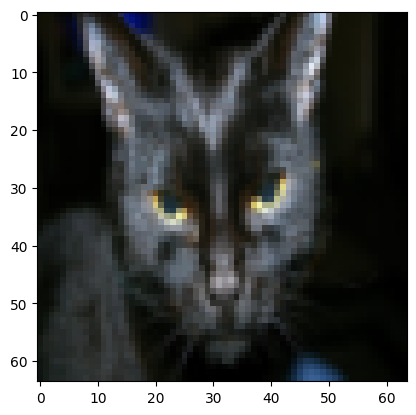

In [55]:
# Пример картинки
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Многие ошибки в машинном обучении возникают из-за несоответствия размерности матрицы/вектора. Если следить за этим, получится избежать большого количества проблем.

**Упражнения:** Найдите значения:
- m_train (величина тренировочной выборки)
- m_test (величина тестовой выборки)
- num_px (= height = width тренировочной картинки)

Помните, что `train_set_x_orig` это numpy-array размерностью (m_train, num_px, num_px, 3). Так например, можно получить `m_train` запросив `train_set_x_orig.shape[0]`.

In [77]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [78]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Количество примеров в обучающей выборке: m_train = " + str(m_train))
print("Количество примеров в тестовой выборке: m_test = " + str(m_test))
print("Высота/ширина каждого изображения: num_px = " + str(num_px))
print("Размер каждого изображения: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Количество примеров в обучающей выборке: m_train = 209
Количество примеров в тестовой выборке: m_test = 50
Высота/ширина каждого изображения: num_px = 64
Размер каждого изображения: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Ожидаемый результат для m_train, m_test и num_px:**

|  |  |
|---|---|
| **m_train** | 209|
| **m_test** | 50|
| **num_px** |  64|

Для удобства, конвертируем изображения размерностью (num_px, num_px, 3) в numpy-array  размерностью (num_px $*$ num_px $*$ 3, 1). После этого, обучающая (и тестовая) выборка станут numpy array, где каждый столбец представляет собой изображение. Теперь должно быть m_train (и соответственно m_test) столбцов.

**Упражнение:** Измените размерность тренировочного и тестового датасета так, что изображения размерностью (num_px, num_px, 3) станут вектором размерностью (num\_px $*$ num\_px $*$ 3, 1).

Когда вы хотите перевести матрицу X размерностью (a,b,c,d) в матрицу X_flatten размером (b$*$c$*$d, a) можно использовать: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T - транспонированная X
```

In [79]:
# Изменение размерности

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("Проверка адекватности результата: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
Проверка адекватности результата: [17 31 56 22 33]


**Ожидаемый результат:**

|  |  |
|---|---|
| **train_set_x_flatten shape** | (12288, 209)|
| **train_set_y shape** | (1, 209)|
| **test_set_x_flatten shape** |  (12288, 50)|
| **test_set_y shape** | (1, 50)|
| **sanity check after reshaping** | [17 31 56 22 33]|

При представлении цветных изображений для каждого пикселя необходимо указать красный, зеленый и синий каналы (RGB), поэтому значение пикселя фактически представляет собой вектор из трех чисел в диапазоне от 0 до 255.

Одним из распространенных шагов предварительной обработки в машинном обучении является центрирование и стандартизация набора данных. Для этого надо вычесть среднее значение всего массива из каждого элемента, а затем разделить каждый элемент на стандартное отклонение массива. 

Но для изображений проще, удобнее и почти так же хорошо работает, если разделить каждую строку набора данных на 255 (максимальное значение пиксельного канала).

Подробнее почитать можно здесь: https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

Давайте стандартизуем наш набор данных.

In [96]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [99]:
train_set_x.shape

(12288, 209)

<font color='blue'>

Общепринятые шаги на этапе предобработки:
- Проверить/выяснить размерность всех элементов (m_train, m_test, num_px, ...)
- Изменить форму датасетов требуемым образом.
- Провести стандартизацию данных

## 3 - Общая архитектура алгоритма обучения ##

Разработаем простой алгоритм, позволяющий отличать изображения кошек от изображений, не относящихся к кошкам.

Строить будем логистическую регрессию, описывая ее как нейрон в нейронной сети.

**Математическое описание алгоритма**:

Для одного элемента $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Затем стоимость рассчитывается путем суммирования всех обучающих примеров.:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Основные шаги**:

В этом упражнении нужно выполнить следующие шаги:

- Инициализировать параметры модели
- Подобрать параметры модели, минимизировав функцию стоимости
- Использовать эти параметры для прогнозирования (на тестовом наборе)
- Проанализировать результаты и сделать выводы.

## 4 - Построение частей алгоритма ## 

Основные этапы построения нейронной сети:

1. Определите структуру модели (например, количество входных объектов).
2. Инициализируйте параметры модели.
3. Цикл:
     - Рассчитать текущие потери (прямое распространение)
     - Рассчитать градиент тока (обратное распространение)
     - Обновление параметров (градиентный спуск)

Реализуем пункты 1-3 отдельно и интегрируем их в одну функцию, которую мы назовем model().

### 4.1 - Вспомогательные функции

**Задача**: Реализуйте функцию `sigmoid()`. Нужно вычислить $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ чтобы сделать предсказания. Используйте np.exp().

In [100]:
def sigmoid(z):
    
    """
    Вычислите сигмоиду от z

    Аргументы:
    z -- Скаляр или numpy array любого размера.

    Ответ:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s

In [101]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Ожидаемый результат:**

|  |  |
|---|---|
| **sigmoid([0, 2])** |  [ 0.5 0.88079708]  |

In [84]:
def initialize_with_zeros(dim):
    
    """
    Эта функция создает вектор нулей размерностью (dim, 1) для w и инициализирует b значением 0.
    
     Аргумент:
     dim — размер желаемого вектора w (или количество параметров в данном случае)
    
     Результат:
     w — инициализированный вектор размера (dim, 1)
     b -- инициализированный скаляр (соответствует смещению)
    """
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [85]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Ожидаемый результат:**

|  |  |
|---|---|
| **w** |  [[ 0.] [ 0.]]  |
| **b** |  0  |

Для входных изображений w будет иметь размерность (num_px ×× num_px ×× 3, 1).

Продолжить с этого момента...

### 4.3 - Прямое и обратное распространение

Теперь, когда ваши параметры инициализированы, вы можете выполнить шаги «прямого» и «обратного» распространения для изучения параметров.

**Задание:** Реализуйте функцию `propagate()`, которая вычисляет функцию стоимости и ее градиент.

**Подсказки**:

Прямое распространение:
- У вас есть X
- Вы вычисляете $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- И вычисляете функцию стоимости: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Две формулы, которые вам понадобятся: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$


**Формула расчета матрицы (7), (8) простой процесс вывода**

**Для удобства объяснения давайте сначала обсудим пример**. 

Из приведенного на лекции рисунка и цепного правила в исчислении мы можем рассчитать:

$$ \frac{\partial L}{\partial w} =  \frac{\partial L}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial w}$$
$$ \frac{\partial L}{\partial b} =  \frac{\partial L}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}$$

- 1.Известно $L(a,y)=-[ylog(a)+(1-y)log(1-a)]$, откуда $$\frac{\partial L}{\partial a} = - \frac{y}{a}+\frac{1-y}{1-a} = \frac{a-y}{a(1-a)} \tag{9}$$

- 2.Кроме того $a = \frac{1}{1+e^{-z}}$，тогда получаем $$\frac{\partial a}{\partial z} = a(1-a) \tag{10}$$

- 3.К тому же $z = w_1x_1+w_2x_2+b$, поэтому $$\frac{\partial z}{\partial w}=[x_1, x_2] \tag{11}$$

Таким же образом существуют $\frac{\partial z}{\partial b} = 1 \tag{12}$

С помощью уравнений (9)~(12) мы можем получить это для одного элемента
$$\begin{align} \frac{\partial L}{\partial w} =\frac{\partial L}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial w}  &= \frac{a-y}{a(1-a)} a(1-a)x \\ &= (a-y)x \end{align}$$
<br>
$$\begin{align} \frac{\partial L}{\partial b} =\frac{\partial L}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}  &= \frac{a-y}{a(1-a)} a(1-a) \\ &= (a-y)\end{align}$$

Для всех элементов формулы (7) и (8) выше имеют следующий вид:

In [86]:
def propagate(w, b, X, Y):
    """
     Реализуйте функцию стоимости и ее градиент для распространения, описанного выше.

     Args:
     w -- веса, массив размером (num_px * num_px * 3, 1)
     b -- смещение, скаляр
     X -- данные размера (num_px * num_px * 3, количество примеров)
     Y -- вектор правильных "меток" (содержащий 0, если не кошка, 1, если кошка) размера (1, количество примеров)

     Result:
     cost: значение функции стоимости для логистической регрессии.
     grads: словарь вида {"dw": dw, "db": db}, где dw - градиент потерь относительно w, то есть той же размерности, 
     что и w, а db - градиент потерь относительно b, то есть той же размерности, что и b
    """
    
    m = X.shape[1]
    
    # Прямое распространение (от X к COST)
    ### НАЧАЛО КОДА ### (≈ 2 строчки)
    A = sigmoid(np.dot(w.T, X) + b)                                  # вычисляем активацию
    cost = -1/m * np.sum(Y* np.log(A) + (1 - Y) * np.log(1 - A))                             # вычисляем стоимость
    ### КОНЕЦ КОДА ###
    
    # Обратное распространение (для поиска градиента)
    ### НАЧАЛО КОДА ### (≈ 2 строчки)
    dw = 1/m * np.dot(X,(A - Y).T)
    db = 1/m * np.sum(A - Y)
    ### КОНЕЦ КОДА ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [87]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Ожидаемый результат:**

|  |  |
|---|---|
| **dw** | [[ 0.99993216] [ 1.99980262]]  |
| **db** |  0.499935230625  |
| **cost** |  6.000064773192205  |

### d) Оптимизация
- Параметры инициализированы.
- Функцию стоимости и ее градиент можем рассчитать.
- Теперь обновим параметры, используя градиентный спуск.

**Задание:** Напишите функцию оптимизации. Задача узнать $w$ и $b$ путем минимизации функции стоимости $J$. Параметр $\theta$ обновляем следующим образом: $ \theta = \theta - \alpha \text{ } d\theta$, где  $\alpha$ - скорость обучения.

In [88]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
     Эта функция оптимизирует w и b, запуская алгоритм градиентного спуска.
    
     Аргументы:
     w -- веса, массив размером (num_px * num_px * 3, 1)
     b -- смещение, скаляр
     X -- данные размером (num_px * num_px * 3, количество примеров)
     Y -- вектор правильных «меток» (содержащий 0, если не кошка, 1, если кошка) размером (1, количество примеров)
     num_iterations -- количество итераций цикла оптимизации
     Learning_rate -- скорость обучения правила обновления градиентного спуска.
     print_cost -- True, чтобы печатать потери каждые 100 итераций.
    
     Результат:
     params -- словарь, содержащий веса w и смещение b
     grads -- словарь, содержащий градиенты весов и смещения относительно функции стоимости.
     costs — список всех стоимостей, вычисленных во время оптимизации, он будет использоваться для построения кривой обучения.
    
     Советы:
     По сути, вам нужно записать два шага и выполнить их:
         1) Рассчитайте стоимость и градиент для текущих параметров. Используйте функцию propagate().
         2) Обновите параметры, используя правило градиентного спуска для w и b.
    """
   
    costs = []
    
    for i in range(num_iterations):
        
        
        # Вычисление функции стоимости и градиента (≈ 1-4 строчки)
        ### НАЧАЛО КОДА ### 
        grads, cost = propagate(w, b, X, Y)
        ### КОНЕЦ КОДА ###
        
        # Получить производные от градиентов
        dw = grads["dw"]
        db = grads["db"]
        
        # Правило обновления (≈ 2 строчки)
        ### НАЧАЛО КОДА ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### КОНЕЦ КОДА ###
        
        # записываем стоимость
        if i % 100 == 0:
            costs.append(cost)
        
        # Выводим стоимость каждые 100 элементов тренировочной выборки
        if print_cost and (i +1)% 100 == 0:
            print ("Cost after iteration %i: %f" %(i+1, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [89]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Ожидаемый результат:**

|  |  |
|---|---|
| **w** | [[ 0.1124579 ] [ 0.23106775]]  |
| **b** | 1.55930492484  |
| **dw** | [[ 0.90158428] [ 1.76250842]]  |
| **db** |  0.430462071679  |

**Задание:** Предыдущая функция выводит изученные значения w и b. Мы можем использовать w и b, чтобы предсказать результаты для датасета X. Реализуйте функцию `predict()`. 

Два шага для вычисления предсказаний:

1. Считаем $\hat{Y} = A = \sigma(w^T X + b)$

2. Преобразовывем a в 0 (если активация <= 0.5) или 1 (если активация > 0.5), сохраняем предказания в вектор `Y_prediction`. Если хотите, В данном примере можно использовать `if`/`else` и цикл `for` (хотя есть и другие способы получения этого вектора). 

In [90]:
def predict(w, b, X):
    '''
     Предскажите, равно ли значение 0 или 1, используя изученные параметры логистической регрессии (w, b)
    
     Аргументы:
     w -- веса, массив размером (num_px * num_px * 3, 1)
     b -- смещение, скаляр
     X -- данные размера (num_px * num_px * 3, количество примеров)
    
     Результат:
     Y_prediction -- массив чисел (вектор), содержащий все прогнозы (0/1) для примеров в X.
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Вычислите вектор "A", предсказывающий вероятность присутствия котика на изображении
    ### НАЧАЛО КОДА ### (≈ 1 строчка)
    A = sigmoid(np.dot(w.T, X) + b)
    ### КОНЕЦ КОДА ###
    
    for i in range(A.shape[1]):
        
        # Преобразуем вероятности A[0,i] в предсказания p[0,i]
        ### НАЧАЛО КОДА ### (≈ 4 строчки)
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        ### КОНЕЦ КОДА ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [91]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**Ожидаемый результат:**

|  |  |
|---|---|
| **предсказания** |[[ 1. 1.]] |

<font color='blue'>
    
Реализовали несколько функций, которые позволяют:
- Инициализировать (w,b)
- Итеративно оптимизировать потери, чтобы подобрать параметры (w,b):
     - расчитали функцию стоимости и ее градиент
     - обновили параметры с помощью градиентного спуска
- Использовать полученные значения (w,b), чтобы предсказать значения для заданного набора примеров.

## 5 - Соединяем все фунции в модель ##

Теперь вы увидите, как структурирована общая модель, соединив вместе все предварительные блоки (функции, реализованные в предыдущих частях) в правильном порядке.

**Задание:** Реализуйте функцию модели. Используйте следующие обозначения:

     - Y_prediction для прогнозов на тестовом датасете
     - Y_prediction_train для прогнозов на тренировочном датасете
     - w, costs, grads для результатов optimize()

In [92]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Строим модель логистической регрессии, вызывая реализованную ранее функцию.
    
     Аргументы:
     X_train -- обучающий набор, представленный массивом размером (num_px * num_px * 3, m_train)
     Y_train -- обучающие значения, представленные массивом (вектором) размером (1, m_train)
     X_test -- набор тестов, представленный массивом размером (num_px * num_px * 3, m_test)
     Y_test -- тестовые значения, представленные массивом (вектором) размера (1, m_test)
     num_iterations -- гиперпараметр, представляющий количество итераций для оптимизации параметров.
     Learning_rate -- гиперпараметр, представляющий скорость обучения, используемую при обновлении optimize().
     print_cost -- установите значение true, чтобы печатать cost каждые 100 итераций.
    
     Результат:
     d -- словарь, содержащий информацию о модели.
    """
    

    ### НАЧАЛО КОДА ###
    
    # инициализируем параметры нулями (≈ 1 строчка)
    w, b = initialize_with_zeros(X_train.shape[0])

    # градиентный спуск (≈ 1 строчка)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # получаем фараметры w и b из словаря "параметров"
    w = parameters["w"]
    b = parameters["b"]
    
    # предсказываем test/train (≈ 2 строчки)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    ### КОНЕЦ КОДА ###

    # выводим train/test ошибки
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Запустите ячейку, чтобы обучить модель

In [93]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Ожидаемый результат:**

|  |  |
|---|---|
| **Train Accuracy** |  99.04306220095694 %  |
| **Test Accuracy** | 70.0 % |

y = 0, you predicted that it is a "cat" picture.


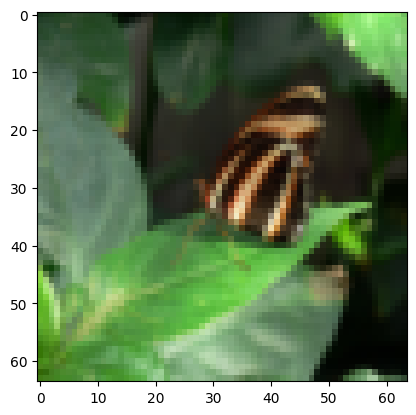

In [94]:
# Пример неправильной классификации изображения.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")


Давайте также построим функцию стоимости и градиенты.

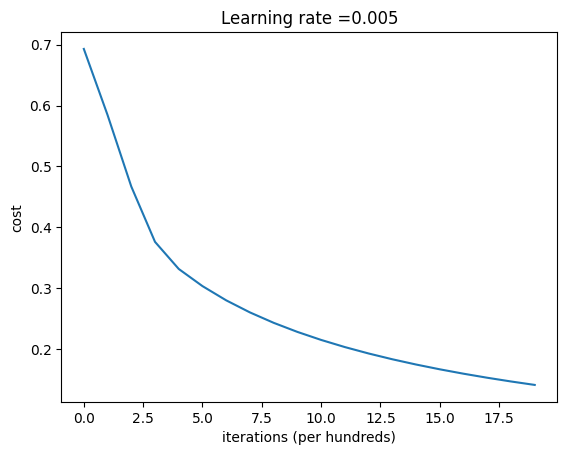

In [95]:
# График кривой обучения (относительно функции стоимости)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Видно, что значение функции стоимости снижается. Это означает, что параметры подбираются успешно. 

Однако на тренировочном наборе модель можно получить лучшие результаты. Можно попробовать увеличить количество итераций в ячейке выше и перезапустить ячейки. 

Точность на обучающей выборке возрастает, но точность на тестовой выборке снизится. Это называется переобучением. 

## 6 - Подбор learning rate ##

Модель построена, давайте подберем $\alpha$. 

$\alpha$ определяет насколько сильно мы изменяем параметры. Если значение будет слишком большим мы можем перескочить оптимальное значение параметра. При малых $\alpha$ можем не дождаться сходимости алгоритма.

learning rate is: 0.03


train accuracy: 100.0 %
test accuracy: 66.0 %

-------------------------------------------------------

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



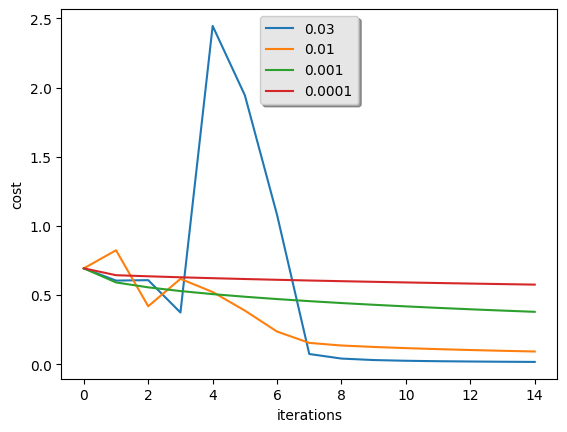

In [97]:
learning_rates = [0.03, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Интерпретация**: 
- Разные $\alpha$ приводят к разным значениям функции стоимости и, соответственно, к разным результатам предсказаний.
- При слишком больших $\alpha$ значение функции стоимости может скакать, также это может привести к тому, что алгоритм не сойдется.
- Малые значения не гарантируют лучшую модель, требуется проверять на возможное переобучение. 
- Выбор скорости обучения обусловлен значением функции потерь и наличием/отсутствием переобучения.

## 7 - Проверка на своем изображении

C:\Users\zavid\AppData\Local\Temp\ipykernel_15716\3939687946.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


y = 1.0, your algorithm predicts a "cat" picture.


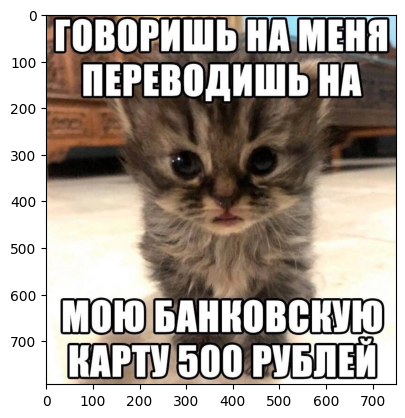

In [105]:
import imageio
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
fname = "cotik.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# Проводим предобработку, чтобы алгоритм мог обработать изображение
image = np.array(imageio.imread(fname))
my_image = np.array(Image.fromarray(image).resize((num_px,num_px))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")